In [7]:
import geopandas as gpd
import xarray as xr
import pandas as pd
import numpy as np

from scipy.spatial import cKDTree



In [3]:
gdf = gpd.read_file("../data/dataset.gpkg")
gdf = gdf.to_crs(4326)
gdf

,iucn_id,sci_name,redlistCategory,vuln,dist_m,distance_km,log_distance_km,index_right,mp_pieces_m3,mp_effective_m3,mp_particles_ml,log_mp_particles_ml,log_toxic_pressure,toxic_pressure,eco_risk_score,eco_risk_index,eco_risk_class,geometry
0,0,Hubbsina turneri,CR,4,244627.454273,244.627454,2.390277,13104,2115.655853,1.587223e+01,1.587223e-05,-4.799362,-6.214335,6.104704e-07,2.441882e-06,1.682364e-02,elevated relative pressure,POINT (-101.4795 19.8745)
1,1,Hubbsina turneri,CR,4,237016.489842,237.016490,2.376607,13104,2115.655853,1.848187e+01,1.848187e-05,-4.733254,-6.148227,7.108413e-07,2.843365e-06,1.958971e-02,elevated relative pressure,POINT (-101.7773 19.8256)
2,2,Hubbsina turneri,CR,4,237235.709534,237.235710,2.377007,13104,2115.655853,1.840102e+01,1.840102e-05,-4.735158,-6.150131,7.077315e-07,2.830926e-06,1.950401e-02,elevated relative pressure,POINT (-101.7876 19.8273)
3,3,Ictalurus mexicanus,VU,2,176956.192726,176.956193,2.250313,13032,2820.874471,8.191469e+01,8.191469e-05,-4.086638,-5.501612,3.150565e-06,6.301130e-06,4.341240e-02,elevated relative pressure,POINT (-99.35417 21.98083)
4,4,Ictalurus mexicanus,VU,2,170585.675721,170.585676,2.234481,13032,2820.874471,9.304551e+01,9.304551e-05,-4.031305,-5.446278,3.578673e-06,7.157347e-06,4.931141e-02,elevated relative pressure,POINT (-99.3 22)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70268,70268,Macrobrachium thysi,VU,2,959001.335033,959.001335,2.982272,11468,0.038661,1.809228e-10,1.809228e-16,-11.999921,-13.414895,3.846850e-14,7.693699e-14,2.650813e-10,low relative pressure,POINT (-3.00185 5.14407)
70269,70269,Macrobrachium thysi,VU,2,929073.410690,929.073411,2.968517,11468,0.038661,3.291880e-10,3.291880e-16,-11.999857,-13.414830,3.847420e-14,7.694840e-14,2.651599e-10,low relative pressure,POINT (-3.52102 5.49955)
70270,70270,Macrobrachium thysi,VU,2,929269.937379,929.269937,2.968609,11468,0.038661,3.278966e-10,3.278966e-16,-11.999858,-13.414831,3.847415e-14,7.694830e-14,2.651592e-10,low relative pressure,POINT (-3.51293 5.49003)
70271,70271,Macrobrachium thysi,VU,2,866968.071829,866.968072,2.938504,11468,0.038661,1.139946e-09,1.139946e-15,-11.999505,-13.414479,3.850538e-14,7.701077e-14,2.655896e-10,low relative pressure,POINT (-4.12282 5.40212)


In [4]:
gdf.geom_type.value_counts()

Point    70273
Name: count, dtype: int64

In [ ]:
# Preparar coordenadas para interpolación
coords = np.column_stack([
    gdf.geometry.x.values,
    gdf.geometry.y.values
])


**** explicar

In [20]:
# Convertir NetCDF a puntos

def sample_nc_to_points(
    nc_path,
    var_name,
    depth_slice=None
):
    ds = xr.open_dataset(nc_path, decode_times=False)
    da = ds[var_name]

    # Profundidad
    if depth_slice and "depth" in da.dims:
        da = da.sel(depth=slice(*depth_slice)).mean("depth")

    # Promediar cualquier dimensión extra (time, month, etc.)
    extra_dims = [d for d in da.dims if d.lower() not in ["lat", "latitude", "lon", "longitude"]]
    if extra_dims:
        da = da.mean(extra_dims)

    # Detectar nombres de latitud y longitud
    lat_name = None
    lon_name = None

    for name in da.dims:
        lname = name.lower()
        if lname in ["lat", "latitude"]:
            lat_name = name
        if lname in ["lon", "longitude"]:
            lon_name = name

    if lat_name is None or lon_name is None:
        raise ValueError(
            f"No se encontraron dimensiones espaciales. Dims encontradas: {da.dims}"
        )
    
    lons = da[lon_name].values
    lats = da[lat_name].values

    lon_grid, lat_grid = np.meshgrid(lons, lats)
    values = da.values.flatten()
    
    # Nearest Neighbor
    tree = cKDTree(
        np.column_stack([lon_grid.flatten(), lat_grid.flatten()])
    )

    _, idx = tree.query(coords, k=1)
    return values[idx]

In [17]:
gdf["temp"] = sample_nc_to_points(
    "../data/ocean/temperature_celsius.nc",
    "t_an",
    depth_slice=(0, 200)
)

gdf["salinity"] = sample_nc_to_points(
    "../data/ocean/salinity.nc",
    "s_an",
    depth_slice=(0, 200)
)

gdf["oxygen"] = sample_nc_to_points(
    "../data/ocean/oxygen_dissolved.nc",
    "o_an",
    depth_slice=(0, 200)
)

gdf["oxygen_util"] = sample_nc_to_points(
    "../data/ocean/oxygen_utilization.nc",
    "A_an",
    depth_slice=(0, 200)
)

gdf["nitrate"] = sample_nc_to_points(
    "../data/ocean/nitrate.nc",
    "n_an",
    depth_slice=(0, 200)
)

gdf["phosphate"] = sample_nc_to_points(
    "../data/ocean/phosphate.nc",
    "p_an",
    depth_slice=(0, 200)
)


In [ ]:

ds = xr.open_dataset(
    "../data/ocean/chlorophyll.nc",
    decode_times=False
)

print(ds)


<xarray.Dataset> Size: 149MB
Dimensions:    (latitude: 4320, longitude: 8640)
Coordinates:
  * latitude   (latitude) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * longitude  (longitude) float32 35kB -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables:
    trend      (latitude, longitude) float32 149MB ...
Attributes:
    area:         GLO
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    references:   http://marine.copernicus.eu
    source:       OCEANCOLOUR_GLO_BGC_L3_MY_009_107
    licence:      http://marine.copernicus.eu/services-portfolio/service-comm...
    convention:   CF-1.7
    institution:  Plymouth Marine Laboratory
    title:        Global Ocean Chlorophyll-a trend
    contact:      https://marine.copernicus.eu/contact


In [19]:
ds = xr.open_dataset("../data/ocean/chlorophyll.nc", decode_times=False)
print(ds)
print("coords:", list(ds.coords))
print("dims:", ds.dims)


<xarray.Dataset> Size: 149MB
Dimensions:    (latitude: 4320, longitude: 8640)
Coordinates:
  * latitude   (latitude) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * longitude  (longitude) float32 35kB -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables:
    trend      (latitude, longitude) float32 149MB ...
Attributes:
    area:         GLO
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    references:   http://marine.copernicus.eu
    source:       OCEANCOLOUR_GLO_BGC_L3_MY_009_107
    licence:      http://marine.copernicus.eu/services-portfolio/service-comm...
    convention:   CF-1.7
    institution:  Plymouth Marine Laboratory
    title:        Global Ocean Chlorophyll-a trend
    contact:      https://marine.copernicus.eu/contact
coords: ['longitude', 'latitude']
dims: FrozenMappingWarningOnValuesAccess({'latitude': 4320, 'longitude': 8640})


In [ ]:
gdf["chl_trend"] = sample_nc_to_points(
    "../data/ocean/chlorophyll.nc",
    "trend"
)


In [24]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 70273 entries, 0 to 70272
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   iucn_id              70273 non-null  int64   
 1   sci_name             70273 non-null  object  
 2   redlistCategory      70273 non-null  object  
 3   vuln                 70273 non-null  int64   
 4   dist_m               70273 non-null  float64 
 5   distance_km          70273 non-null  float64 
 6   log_distance_km      70273 non-null  float64 
 7   index_right          70273 non-null  int64   
 8   mp_pieces_m3         70273 non-null  float64 
 9   mp_effective_m3      70273 non-null  float64 
 10  mp_particles_ml      70273 non-null  float64 
 11  log_mp_particles_ml  70273 non-null  float64 
 12  log_toxic_pressure   70273 non-null  float64 
 13  toxic_pressure       70273 non-null  float64 
 14  eco_risk_score       70273 non-null  float64 
 15  eco_risk_in

<Axes: >

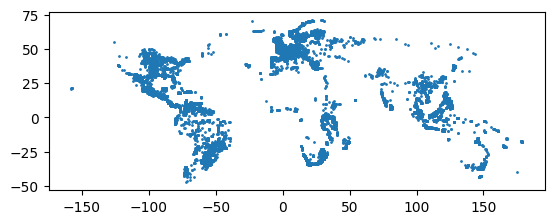

In [25]:
missing = gdf[gdf["temp"].isna()]

missing.plot(markersize=1)


In [34]:
woa_vars = [
    "temp","salinity","oxygen","oxygen_util",
    "nitrate","phosphate"
]

valid = gdf.dropna(subset=woa_vars).copy()
missing = gdf[gdf[woa_vars].isna().any(axis=1)].copy()


In [36]:
coords_valid = np.column_stack([
    valid.geometry.x.values,
    valid.geometry.y.values
])

coords_missing = np.column_stack([
    missing.geometry.x.values,
    missing.geometry.y.values
])



In [37]:
tree = cKDTree(coords_valid)
dist, idx = tree.query(coords_missing, k=1)


In [62]:
MAX_DIST = 10  # grados ~ 25 km en el ecuador


In [63]:
mask = dist <= MAX_DIST

for var in woa_vars:
    missing.loc[mask, var] = valid.iloc[idx[mask]][var].values



In [64]:
gdf_filled = gdf.copy()
gdf_filled.update(missing)



In [65]:
gdf_filled.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 70273 entries, 0 to 70272
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   iucn_id              70273 non-null  int64   
 1   sci_name             70273 non-null  object  
 2   redlistCategory      70273 non-null  object  
 3   vuln                 70273 non-null  int64   
 4   dist_m               70273 non-null  float64 
 5   distance_km          70273 non-null  float64 
 6   log_distance_km      70273 non-null  float64 
 7   index_right          70273 non-null  int64   
 8   mp_pieces_m3         70273 non-null  float64 
 9   mp_effective_m3      70273 non-null  float64 
 10  mp_particles_ml      70273 non-null  float64 
 11  log_mp_particles_ml  70273 non-null  float64 
 12  log_toxic_pressure   70273 non-null  float64 
 13  toxic_pressure       70273 non-null  float64 
 14  eco_risk_score       70273 non-null  float64 
 15  eco_risk_in

In [31]:
gdf["lon"] = gdf.geometry.x
gdf["lat"] = gdf.geometry.y


In [32]:
gdf["depth"] = 0        # superficie
gdf["time"] = 0         # media anual


In [34]:
temp = ds["t_an"].sel(
    lat=xr.DataArray(gdf["lat"], dims="obs"),
    lon=xr.DataArray(gdf["lon"] % 360, dims="obs"),
    depth=xr.DataArray([0] * len(gdf), dims="obs"),
    time=0,
    method="nearest"
)



In [35]:
gdf["temp_woa"] = temp.values
gdf

,sci_name,presence,origin,seasonal,lon,lat,redlistCategory,geometry,depth,time,temp_woa
0,Hubbsina turneri,1,1,1,-101.47950,19.87450,CR,POINT (-101.4795 19.8745),0,0,27.29011
1,Hubbsina turneri,1,1,1,-101.77730,19.82560,CR,POINT (-101.7773 19.8256),0,0,27.29011
2,Hubbsina turneri,1,1,1,-101.78760,19.82730,CR,POINT (-101.7876 19.8273),0,0,27.29011
3,Ictalurus mexicanus,1,1,1,-99.35417,21.98083,VU,POINT (-99.35417 21.98083),0,0,26.87191
4,Ictalurus mexicanus,1,1,1,-99.30000,22.00000,VU,POINT (-99.3 22),0,0,26.61310
...,...,...,...,...,...,...,...,...,...,...,...
70268,Macrobrachium thysi,1,1,1,-3.00185,5.14407,VU,POINT (-3.00185 5.14407),0,0,29.13829
70269,Macrobrachium thysi,1,1,1,-3.52102,5.49955,VU,POINT (-3.52102 5.49955),0,0,29.13829
70270,Macrobrachium thysi,1,1,1,-3.51293,5.49003,VU,POINT (-3.51293 5.49003),0,0,29.13829
70271,Macrobrachium thysi,1,1,1,-4.12282,5.40212,VU,POINT (-4.12282 5.40212),0,0,29.13829


In [ ]:
gdf["temp_woa"].info()


<class 'pandas.core.series.Series'>
RangeIndex: 70273 entries, 0 to 70272
Series name: temp_woa
Non-Null Count  Dtype  
--------------  -----  
38139 non-null  float32
dtypes: float32(1)
memory usage: 274.6 KB


<Axes: >

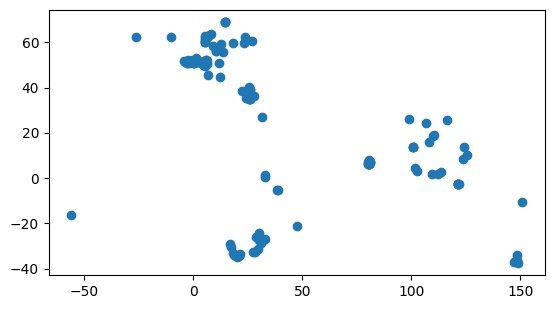

In [ ]:
gdf[gdf["temp_woa"].isna()].geometry.sample(200).plot()
